# Churn Prediction - Binary Classification
This notebook uses features identified as promising in the EDA notebook. It investigates correlations between features, removes NaNs and outliers, looks for class imbalance and finally trains a Gradient Boosting Classifier using Randmized Search.

Author: Daniel Grzebyk

Date: August 7th, 2022

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix,classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

sys.path.append("C:\\Users\\danie\\PycharmProjects\\data_analysis\\utils\\")
from classification_utils import chi_test, chi_test_new, find_boolean_features, find_correlated_features, remove_outliers, plot_learning_curve

## Loading the data

In [2]:
selected_features = ['mou_opkv_Mean','months', 'uniqsubs', 'actvsubs', 'hnd_price', 'truck', 'rv', 'adults', 'income',
                     'eqpdays','new_cell', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'marital', 'infobase',
                     'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'churn']
# selected_features = ['eqpdays', 'months', 'mou_opkv_Mean', 'hnd_price', 'churn']

df = pd.read_csv("../data/telecom/data.csv", usecols=selected_features)
var_df = pd.read_csv("../data/telecom/variables-definition.csv")

In [3]:
X = df.drop(columns=['churn']).copy()
y = df['churn'].copy()

In [4]:
X.shape

(100000, 22)

### Investigating Correlations
Ideally, features should be correlated with the label and not correlated with each other. As Pearson correlation reveals only linear dependencies, its value between features and label are not conclusive. A feature might have low value of Pearson correlation, but have strong predictive power. Therefore, features with low correlation with churn are __not__ removed. 

1. Removing features correlated with other features
2. Finding features uncorrelated with churn (label)

#### Categorical Features
Chi test revealed that handest web capacity is the most promising of all categorical features. 

In [5]:
cat_features = X.select_dtypes(include='object').columns
cat_features

Index(['new_cell', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'marital',
       'infobase', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17'],
      dtype='object')

In [6]:
cat_features = X.select_dtypes(include='object').columns

my_x = X[cat_features].dropna().copy()
my_y = y.loc[my_x.index]

one_hot = OneHotEncoder(sparse=False)  # handle_unknown='ignore'
my_x_enc = one_hot.fit_transform(my_x)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(my_x_enc, my_y)

X_train_chi = chi2_selector.transform(my_x_enc)

In [7]:
feature_names = one_hot.get_feature_names(cat_features)

chi_df = pd.DataFrame({"feature": feature_names, "score": chi2_selector.scores_, "p_value": chi2_selector.pvalues_})
chi_df.loc[chi_df['p_value'] < 0.05].sort_values(by='p_value', ascending=True).head()

C:\Users\danie\anaconda3\envs\data_analysis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,score,p_value
29,hnd_webcap_WC,311.278190,1.150221e-69
27,refurb_new_R,71.981433,2.172317e-17
16,area_NORTHWEST/ROCKY MOUNTAIN AREA,64.364388,1.034105e-15
30,hnd_webcap_WCMB,58.362259,2.180338e-14
22,dualband_N,52.025357,5.478853e-13


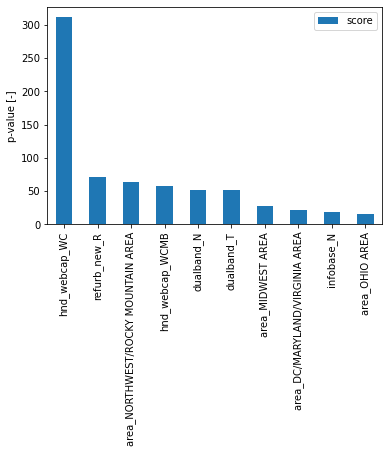

In [8]:
chi_df.nsmallest(10, columns=['p_value']).plot(x='feature', y='score', kind='bar')
plt.xlabel("")
plt.ylabel("p-value [-]")
plt.show()

#### Numerical features
Continous numerical features are also investigated looking for correlations. Handest price is inversely correlated with its age which is intuitive as phones become cheaper with time and fatigue. Equipment age has weak correlation with age in months which might indicate that some clients have not changed their devices since their first contract with the telecom company. The remaining features are not correlated between themselves and with the target value. This, together with the findings in EDA is a warning that the dataset might not contain enough information to predict churn.

In [9]:
num_features = df.select_dtypes(include='number').columns
num_features

Index(['mou_opkv_Mean', 'churn', 'months', 'uniqsubs', 'actvsubs', 'hnd_price',
       'truck', 'rv', 'adults', 'income', 'eqpdays'],
      dtype='object')

<AxesSubplot:>

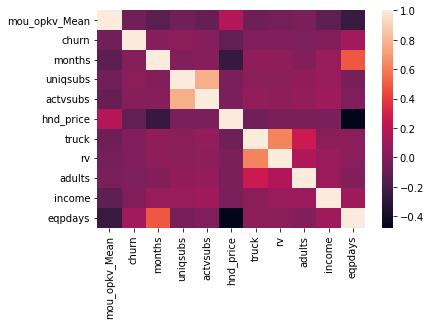

In [10]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)

## Data Preprocessing
### Removing duplicates

In [11]:
X.duplicated().sum()

25

In [12]:
X.drop_duplicates(inplace=True)

### Removing outliers

In [13]:
def remove_outliers_iqr(X, cols):
    for col in cols:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        X.loc[mask, col] = np.nan
    return X

In [14]:
num_features = X.select_dtypes(include='number').columns
X = remove_outliers_iqr(X, num_features)

### Removing NaNs
Some columns have so many missing values that keeping them would leave us with too small dataset. Therefore, firstly entire columns with too many missing values are removed and then NaNs are dropped per row. 

In [15]:
# Count NaNs
nans_per_feature = X.isna().sum()
nans_per_feature[nans_per_feature > 10000].sort_values(ascending=False)  # Is one of the dropped features crucial?

income        25418
adults        23001
infobase      22061
truck         20287
hnd_webcap    10187
dtype: int64

In [16]:
cols_to_drop = list(nans_per_feature[nans_per_feature > 10000].index)  # drop features which have more than 20% NaNs
X.drop(columns=cols_to_drop, inplace=True)
print("Dropping:", cols_to_drop)

print("Before dropping rows with NaNs:", X.shape)
X.dropna(inplace=True)
y = y.loc[X.index]
print("After dropping rows with NaNs:", X.shape)

Dropping: ['hnd_webcap', 'truck', 'adults', 'infobase', 'income']
Before dropping rows with NaNs: (99975, 17)
After dropping rows with NaNs: (75009, 17)


### Looking for class imbalance

In [17]:
y.value_counts()

0    37693
1    37316
Name: churn, dtype: int64

In [18]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns
len(num_features), len(cat_features)

(7, 10)

## Predicting churn
80% of data is assigned to the training set and the remaining 20% to the validation set. It would be beneficial to evaluate model performance also on a test (left out) set to measure the real life performance. Test set is not created, as the model did not perform well on the validation set. 

### Splitting the data

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape

(60007, 17)

### Training the model
Numerical features with low variance are removed, 5 best categorical features are retained for training the model. Several algorithms including Naive Bayes, Support Vector Classifier, Decision Tree, Random Forest and Gradient Boosting classifiers were tested. Although some of them provided relatively good recall above 0.7, the precision remained low. 

It is unclear what is the cost of offering an incentive (discount?) to a potential churner who infact is not considering to leave (false positive). It is assumed that it is lower than the cost of failing to predict who the next churner is and letting him/her leave (false negative). Therefore, recall is more important then precision, but we want to prevent a situation when everybody is offered a discount. F1 score is used to compromise between precision and recall.

In [21]:
# %%time
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), 
           ("var_thr", VarianceThreshold(threshold=0.1))]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("cat_selector",  SelectKBest(chi2, k=5))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder = 'passthrough',
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", (GradientBoostingClassifier()))]
)

# pipeline.fit(X_train, y_train)
# print("model score: %.3f" % pipeline.score(X_val, y_val))

In [22]:
%%time
# GRADIENT BOOSTING
hyperparameter_grid = {
    'classifier__n_estimators': [10, 50, 100, 150, 200],
    'classifier__learning_rate': [1, 3, 10, 30, 100],
    'classifier__subsample': [0.3, 0.6, 0.9, 1],
    'classifier__max_depth': [5, 10, 20]
}


random_cv = RandomizedSearchCV(estimator=pipeline,
            param_distributions=hyperparameter_grid,
            cv=3, 
            n_iter=5,
            scoring = 'f1',
            n_jobs = -1,
            verbose = 0,
            error_score='raise',
            return_train_score = True,
            random_state=42)


random_cv.fit(X_train, y_train)

CPU times: total: 10.9 s
Wall time: 3min 26s


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('var_thr',
                                                                                                VarianceThreshold(threshold=0.1))]),
                                                                               Index(['mou_opkv_Mean', 'months', 'uniqsubs', 'actvsubs', 'hnd_price', 'rv',
       'eqpdays'],
      dtype='object')),
                                                                              (...
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17'],
      dtype='object'))])),
                                             ('classifier',
                                              GradientBoostingClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [1, 3, 10,
                                                                      30, 100],
                                        'classifier__max_depth': [5, 10, 20],
                                        'classifier__n_estimators': [10, 50,
                                                                     100, 150,
                                                                     200],
                                        'classifier__subsample': [0.3, 0.6, 0.9,
                                                                  1]},
                   random_state=42, return_train_score=True, scoring='f1')

In [23]:
random_cv.best_params_

{'classifier__subsample': 0.6,
 'classifier__n_estimators': 100,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 1}

### Inference

In [24]:
# Train Inference
y_pred = random_cv.best_estimator_.predict(X_train) # selector.estimator_ # random_cv.best_estimator_
y_val_pred = random_cv.best_estimator_.predict(X_val) # selector.estimator_ # random_cv.best_estimator_

### Evaluation
The model suffers from high variance which was addressed by increasing regulatization in SVC, and reducing the subset and depth of trees in Random Forest. Despite trying several algorithms and hyperparameter configuration, the best achieved validation recall was ~0.7 and validation precision ~0.6. The training metrics were near 1.0 which indicated high variance. Variance reduction techniques implemented were: for SVC reducing regularization, for Random Forest reducing subset of features available for each tree, reducing max depth and number of the trees. These changes were insufficient to tackle high variance.

High variance together with few differences between the populations of churners and non-churners leads to the conclusion that the dataset is insufficient to predict churn. Other features such as pricing of products and information about competition might be required to successfully predict churn.

In [25]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

Train Accuracy: 0.66
Train Precision: 0.65
Train Recall: 0.69

Validation Accuracy: 0.57
Validation Precision: 0.56
Validation Recall: 0.59


## Error Analysis / Postprocessing
The most important features turned out to be: mean unrounded minutes of use of off-peak voice calls (mou_opkv), equipment age in days, and months a customer has stayed with the telecom provider.

### Feature Importance

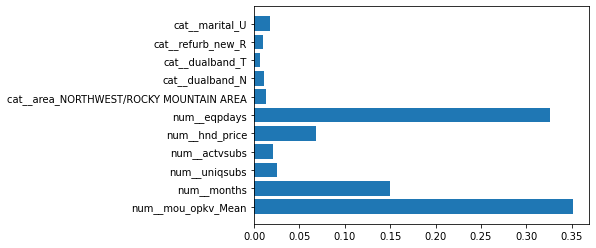

In [26]:
feature_names = random_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = random_cv.best_estimator_.steps[1][1].feature_importances_
plt.barh(width=feature_importances, y=feature_names)
plt.show()

### Learning Curve
In the left most figure (learning curve) it can be seen that learning error does not reduce over time, and that the model suffers from high variance.

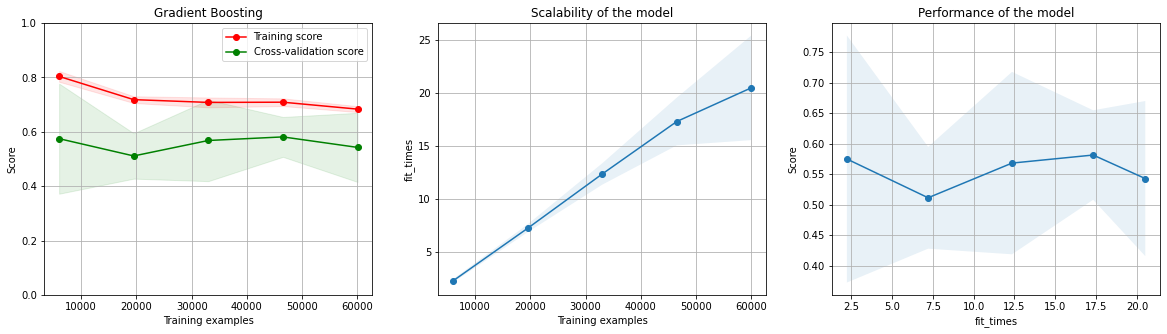

In [27]:
plot_learning_curve(estimator=random_cv.best_estimator_,
                    title='Gradient Boosting',  # Random Forest
                    X=X, 
                    y=y, 
                    axes=None, 
                    ylim=[0, 1], 
                    cv=5, 
                    n_jobs=-1, 
                    scoring='recall',
                    train_sizes=np.linspace(.1, 1.0, 5))
plt.show()